considers only direct parents and children, not ancestors or descendants

In [68]:
from margprob import *
from similarityfunctions import *
import itertools as it
import portion

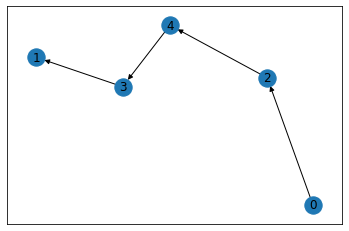

In [69]:
dg = makeDirectedGraph(5, 12)
nx.draw_networkx(dg)

In [70]:
def CPT(graph, values):
    nodes = list(graph.nodes())
    CPT = list(it.product(values, repeat=len(nodes)))
    return CPT

def possible_outcomes(graph, values):
    nodes = list(graph.nodes())
    cpt = CPT(graph, values)
    list_outcomes = []
    for i in cpt:
        list_outcomes.append(dict(zip(nodes, i)))
    return list_outcomes

In [71]:
def approx_node_weight(parent, child, conditional_prob):
    '''Accepts a conditional probability value P(A|B), calculates possible probabilities of the adjacent node'''
    #instantiate root nodes
    if (dg.in_degree(parent) == 0): parent_prob = .9
    else: parent_prob = random.uniform(0,1)
    
    #instantiate terminal nodes
    if (dg.out_degree(child) == 0): child_prob = 1
    else: child_prob = random.uniform(0,1)
        
    likelihood = (conditional_prob*child_prob)/parent_prob
    known_conditional_prob = (parent_prob*likelihood)/child_prob
    
    if (known_conditional_prob != conditional_prob):
        return approx_node_weight(parent, child, conditional_prob)
    else: 
        dg.nodes[parent]['weight'] = parent_prob
        dg.nodes[child]['weight'] = child_prob
        return parent_prob, child_prob

In [72]:
# assign intrinsic probability to root and terminal nodes
def gen_node_weights(dg):
    '''Accepts a conditional probability value P(A|B), returns P(B|A) and a pair of values for P(A) and P(B) that
        would be consistent with the given conditional probability for each node in the graph'''
    nodes = list(dg.nodes())
    edges = list(dg.edges())
    roots = [root for root in nodes if (dg.in_degree(root) == 0)]
    terminal_nodes = [t for t in list(set(nodes) - set(roots)) if (dg.out_degree(t) == 0)] 

    unknown_nodes = list(set(roots) - set(terminal_nodes))
    for node in nodes:
        weight_approx = []
        for edge in edges:
            conditional_prob = dg[edge[0]][edge[1]]['weight']
            node_prob = approx_node_weight(edge[0], edge[1], conditional_prob)
            if (node == edge[0]): weight_approx.append(node_prob[0])
            else: weight_approx.append(node_prob[1])
        dg.nodes[node]['weight'] = mean(weight_approx)
        
    return dg.nodes()

In [73]:
gen_node_weights(dg)

NodeView((0, 1, 2, 3, 4))

In [74]:
nx.get_node_attributes(dg, 'weight')

{0: 0.9,
 1: 1,
 2: 0.519961026257371,
 3: 0.04330112068718339,
 4: 0.7680319585601072}

In [75]:
# pick a node, calculate the marg prob
def margProb(dg, outcome, node):
    parents = list(dg.predecessors(node))
    #assign value to each node
    for n in list(dg.nodes()):
        dg.nodes[n]['value'] = outcome.get(n)
        if (dg.nodes[n]['value'] == False): dg.nodes[n]['weight'] = 1 - dg.nodes[n]['weight']

    node_value = dg.nodes[n]['value']
    node_prob = dg.nodes[n]['weight']

    #calculate prob of node given parents
    cp = []
    if not parents:
        margprob = node_prob
    else:
        for p in parents:
            edge_weight = dg[p][node]['weight']
            cp += [edge_weight]
        cp.append(node_prob)
        margprob = multiplyList(cp)
    
    return outcome, margprob
    

In [91]:
def rootMargProb(dg, outcome, root_node):
    all_nodes = list(dg.nodes)
    all_ancestors = [node for node in all_nodes if (node in list(nx.ancestors(dg, root_node)))]
    
    dg.nodes[root_node]['value'] = outcome.get(root_node)
    if (dg.nodes[root_node]['value'] == False): dg.nodes[root_node]['weight'] = 1 - dg.nodes[root_node]['weight']
    root_prob = dg.nodes[root_node]['weight']
    
    prob_list = [root_prob]
    for a in all_ancestors:
        # for root's direct children
        if a in list(dg.successors(root_node)):
            cpd.append(dg[root_node][a]['weight'])
        else: 
            prob_list.append(margProb(dg, outcome, a))
        
    rootProb = multiplyList(prob_list)
    return outcome, rootProb
    

In [92]:
# pick a node, calculate the marg prob
def total_marginal_calculation(dg, node):
    worlds = possible_outcomes(dg, [True, False])
    marg_dist = []
    
    if node in [r for r in list(dg.nodes()) if (dg.in_degree(r) == 0) and dg.successors(r)]:
        for w in worlds:
            nodeMarg = rootMargProb(dg, w, node)
            marg_dist.append(nodeMarg)
        return marg_dist
    else:
        for w in worlds:
            nodeMarg = margProb(dg, w, node)
            marg_dist.append(nodeMarg)
        return marg_dist

# Test

In [93]:
total_marginal_calculation(dg, 3)

[({0: True, 1: True, 2: True, 3: True, 4: True}, 0.3820162030261044),
 ({0: True, 1: True, 2: True, 3: True, 4: False}, 0.11538002999302889),
 ({0: True, 1: True, 2: True, 3: False, 4: True}, 0.11538002999302889),
 ({0: True, 1: True, 2: True, 3: False, 4: False}, 0.3820162030261044),
 ({0: True, 1: True, 2: False, 3: True, 4: True}, 0.3820162030261044),
 ({0: True, 1: True, 2: False, 3: True, 4: False}, 0.11538002999302889),
 ({0: True, 1: True, 2: False, 3: False, 4: True}, 0.11538002999302889),
 ({0: True, 1: True, 2: False, 3: False, 4: False}, 0.3820162030261044),
 ({0: True, 1: False, 2: True, 3: True, 4: True}, 0.3820162030261044),
 ({0: True, 1: False, 2: True, 3: True, 4: False}, 0.11538002999302889),
 ({0: True, 1: False, 2: True, 3: False, 4: True}, 0.11538002999302889),
 ({0: True, 1: False, 2: True, 3: False, 4: False}, 0.3820162030261044),
 ({0: True, 1: False, 2: False, 3: True, 4: True}, 0.3820162030261044),
 ({0: True, 1: False, 2: False, 3: True, 4: False}, 0.11538002

In [95]:
for node in list(dg.nodes()):
    print(node)
    print(total_marginal_calculation(dg, node))
    print()

0
[({0: True, 1: True, 2: True, 3: True, 4: True}, 0.9), ({0: True, 1: True, 2: True, 3: True, 4: False}, 0.9), ({0: True, 1: True, 2: True, 3: False, 4: True}, 0.9), ({0: True, 1: True, 2: True, 3: False, 4: False}, 0.9), ({0: True, 1: True, 2: False, 3: True, 4: True}, 0.9), ({0: True, 1: True, 2: False, 3: True, 4: False}, 0.9), ({0: True, 1: True, 2: False, 3: False, 4: True}, 0.9), ({0: True, 1: True, 2: False, 3: False, 4: False}, 0.9), ({0: True, 1: False, 2: True, 3: True, 4: True}, 0.9), ({0: True, 1: False, 2: True, 3: True, 4: False}, 0.9), ({0: True, 1: False, 2: True, 3: False, 4: True}, 0.9), ({0: True, 1: False, 2: True, 3: False, 4: False}, 0.9), ({0: True, 1: False, 2: False, 3: True, 4: True}, 0.9), ({0: True, 1: False, 2: False, 3: True, 4: False}, 0.9), ({0: True, 1: False, 2: False, 3: False, 4: True}, 0.9), ({0: True, 1: False, 2: False, 3: False, 4: False}, 0.9), ({0: False, 1: True, 2: True, 3: True, 4: True}, 0.09999999999999998), ({0: False, 1: True, 2: True, 

In [96]:
nx.get_edge_attributes(dg, 'weight')

{(0, 2): 0.22882094656633023,
 (2, 4): 0.12531636350885988,
 (3, 1): 0.6652240586907557,
 (4, 3): 0.49739623301913327}

In [97]:
nx.get_node_attributes(dg, 'weight')

{0: 0.9,
 1: 1,
 2: 0.519961026257371,
 3: 0.04330112068718339,
 4: 0.7680319585601072}